# Clasificación y agrupación de Radio Galaxias

Gracias a los nuevos surveys de radio galaxias tenemos miles de imágenes de radio galaxias que nos podrían ayudar a entender las propiedades de estas. Sin embargo la cantidad de datos hace imposible el anális manual y se requieren nuevas técnicas automatizadas como "Machine Learning". 

El problema pincipal con Machine Learning sobre imágenes es la rotación y translación de las mismas. Si tomamos una imágen y la rotamos podemos ver que la distancia euclediana no es cero. Por lo que si usamos esta métrica tendríamos problemas agrupando imágenes muy similares pero con rotaciones distintas.

In [3]:
from keras.datasets import mnist #usamos keras para descargar MNIST
import matplotlib.pyplot as plt #matplotlib para graficar
from numba import jit #easy paralleization
import numpy as np

Using TensorFlow backend.


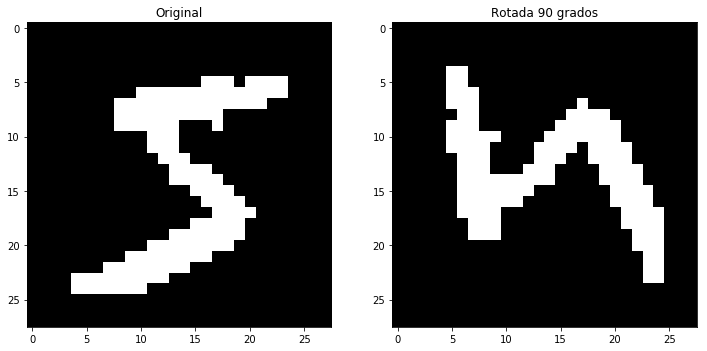

Norma de Original - Rotada : 15.684387141358123


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
im1 = x_train[0] > 50 #umbral fijo para el ejemplo
f, ax = plt.subplots(1, 2, figsize=(12,15))
imr = np.rot90(im1)
ax[0].set_title('Original')
ax[0].imshow(im1, cmap='gray')
ax[1].set_title('Rotada 90 grados')
ax[1].imshow(imr, cmap='gray')
plt.show()
nrm = np.linalg.norm(im1 ^ imr)
print("Norma de Original - Rotada : {0}".format(nrm))

En la literatura actual de agrupación de radio galaxias vemos que el uso de Self Organizing Maps (SOM) tiene cierta popularidad. SOM es un algoritmo cuyo objetivo es organizar datos de tal forma que los objetos más similares entre si se encuentren juntos, de tal forma que dos datos lejanos son muy diferentes mientras que dos cercanos son similares. Esta similitud usualmente se mide con la distancia Euclediana, pero como ya vimos esta tiene problemas en el area de imágenes ya que no es invariante a rotación o translación. Afortunadamente las imágenes de Surveys de Radio vienen centrados en las fuentes emisoras, por lo que nos ahorramos el problema de translación. Para el problema de rotación vimos dos soluciones, la propuesta por T.J. Galvin y N.O. Ralph.

La solución de Galvin es muy similar a una propuesta por [K.L. Polsterer](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.720.8082&rep=rep1&type=pdf) en la cual para cada dato (fuente emisora) se generan rotaciones de la imágen original en incrementos de un grado, de tal forma que por cada dato tenemos 360 imágenes. Una vez teniendo esto podemos tomar la distancia entre dos datos como la distancia eucledina mínima entre la imágen original de un dato y las 360 del otro. Lo bueno de esta solución es que fácil de entender, es bastante robusta y altamente paralelizable, lamentablemente cuandos se usa en conjuntos de datos muy grandes se requiere bastante poder de computo.

Por otra parte la solución propuesta por Ralph intenta minimizar la cantidad de computo utilizado. Esto lo logra usando una red neuronal convolucionada como auto-encoder con la finalidad de disminuir la dimensión del problema y al meter rotaciones aleatorias de los datos originales durante el entrenamiento se espera que el encoding sea invariante a rotación. Una vez entrenada la red, podemos tomar los datos cifrados y aplicar SOM. En este algoritmo la robustes y la cantidad de poder de computo utilizado dependeran del número de iteraciones utilizadas para entrenar la red al igual que del tamaño de la reducción de dimensión que se realiza.

Como parte de nuestro proyecto proponemos usar técnicas distitnas que nos permitan aplicar técnicas de análisis estadísticio sobre datos invariatnes a rotación y translación obtenidos de las imágenes originales.

## Propuesta

<!-- Nos gustaría generar un nuevo algorimo que nos permita agrupar las radio galaxias que sea invariante a rotación, a su vez nos gustaría algo más sencillo que rotar las imágenes un grado, creando un conjuto de datos considerablemente más grande que el original. Actualmente tenemos dos opciones.

### Cambio de métrica de distancia
Tanto Galvin como Ralph usan la distancia Euclidiana para realizar SOM, el problema con esta métrica es que es sensible a translación y rotación, pero existen otras métricas que nos podrían ser útiles. 

#### Procrustes Shape Distance
 Para esta métrica comenzamos buscando la imágen promedio, y rotamos todas las demás imágenes de tal forma que minimizamos la distancia euclediana entre ellas y la imágen promedio. Este proceso se repite hasta que la imágen promedio no cambie. 
 Lamentablemente este proceso podría llegar a ser muy tardado y no nos daría una ventaja sobre los algoritmos ya existentes, sin embargo podríamos utilizar un subconjuto de los datos para generar la imágen promedio y rotar el resto de los datos usando esta imágen promedio. Teniendo todas las imágenes rotadas podemos usar SOM o algún otro método que nos permita vizualizar, como ISOMAP, K-Means, etc.
-->

### Análisis Morfológico

Podemos extraer información invariente a rotación y translación de nuestras imágenesy realizar el análisis sólo sobre esta información, de esta forma no necesitaríamos rotar las imagenes lo cual posiblemente nos ahorraría tiempo.

Una forma de obtener algo de información invariante bajo transalación y rotación es tomar un elemento estructurante circular, conservar el area sobre la cual este cabe y comprarar los cambios de area, esta operación es equivalente a un Opening morfológico, podemos tomar diferentes tamaños y así obtener bastante información.

Otra opción sería tomar el elemento estructurante y pasarlo sobre el contorno de la forma, de esta forma agrandando la forma. Tambíen podríamos usar ambas técnicas en conjunto, obteniendo así más información.

El opening morfologico consite en dos opearciones, erosión y dilatación. La erosión se obtiene al pasar el elemento estructurante sobre la imágen y se conservan sólo los pixeles centrales donde el elemento estructurante cabe por completo, es decir todo el elemento estructurante está sobre pixeles blancos.

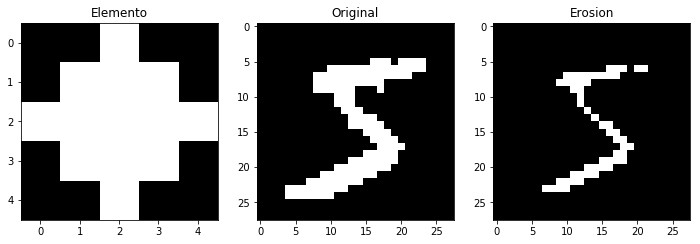

In [5]:
import skimage.morphology as morpho
f, ax = plt.subplots(1, 3, figsize=(12,15))
d1 = morpho.disk(2)
ax[0].set_title('Elemento')
ax[0].imshow(d1, cmap='gray')
ax[1].set_title('Original')
ax[1].imshow(im1, cmap='gray')
ax[2].set_title('Erosion')
ax[2].imshow(morpho.erosion(im1), cmap='gray')
plt.show()

La dilatación se puede ver como el proceso inverso (aun que no lo es del todo), aquí tomamos la imágen y pasamos el centro del elemento estructurante sobre la imágen cambiando a blanco aquellos pixeles sobre los que pase cualquier parte del elemento estructurante.

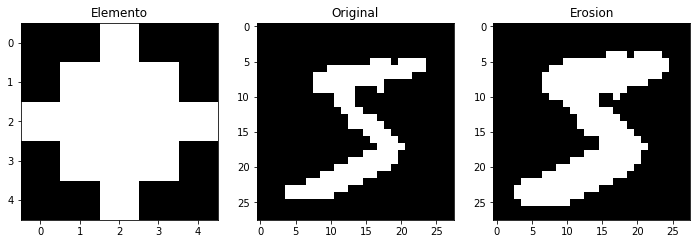

In [6]:
f, ax = plt.subplots(1, 3, figsize=(12,15))
ax[0].set_title('Elemento')
ax[0].imshow(d1, cmap='gray')
ax[1].set_title('Original')
ax[1].imshow(im1, cmap='gray')
ax[2].set_title('Erosion')
ax[2].imshow(morpho.dilation(im1), cmap='gray')
plt.show()

Combinando estas operaciones para crear el opening morfológico y usando diferentes tamaños de elementos estructurantes podemos obtener información de las forma en la imágen.

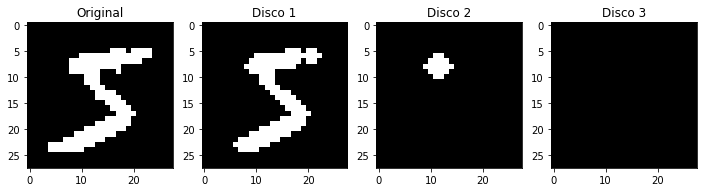

In [7]:
import skimage.morphology as morpho
f, ax = plt.subplots(1, 4, figsize=(12,15))
ax[0].imshow(im1, cmap='gray') #umbral fijo para el ejemplo
ax[0].set_title('Original')
for i in range(1, 4):
    d1 = morpho.disk(i)
    imo = morpho.opening(im1, d1)
    ax[i].imshow(imo, cmap='gray')
    st = 'Disco ' + str(i)
    ax[i].set_title(st)
plt.show()

Al igual, usando el closing morfologico (dilatacion seguida por erosión) 

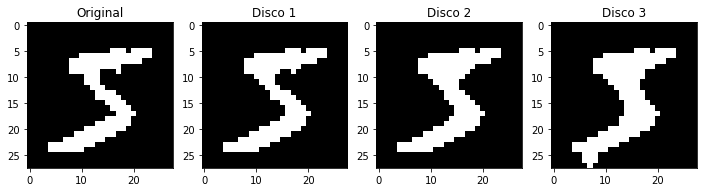

In [8]:
import skimage.morphology as morpho
f, ax = plt.subplots(1, 4, figsize=(12,15))
ax[0].imshow(im1, cmap='gray') #umbral fijo para el ejemplo
ax[0].set_title('Original')
for i in range(1, 4):
    d1 = morpho.disk(i)
    imo = morpho.closing(im1, d1)
    ax[i].imshow(imo, cmap='gray')
    st = 'Disco ' + str(i)
    ax[i].set_title(st)
plt.show()

Podemos aplicar las mismas operaciones sobre imágenes de radio galaxias, pero para evitar hacer umbralizados debemos usar un elemento estructurante que no sólo sea blanco y negro. Si vemos una imágen como un objeto tridimencional, donde la intensidad de cada pixel es el tercer eje, podemos aplicar los operadores morfológicos en tres dimenciones.

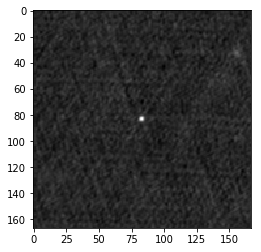

In [9]:
fits_dir = '../imgs/first' #directorio donde tenemos imagenes FIRST
from astropy.io import fits
import skimage as sk
im = fits.open('{0}/J145615+605322.fits'.format(fits_dir))
plt.imshow(im[0].data, cmap='gray')
plt.show()

In [11]:
%%time
import numpy as np
@jit(nopython=True)
def discretize_img(img, n_div):
    min_b, max_b = 10, -100
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i,j] < min_b): min_b = img[i,j]
            if(img[i,j] > max_b): max_b = img[i,j]
    discrete_sz = (max_b - min_b) / (float(n_div) + 1.0)
    discrete_img = np.zeros((img.shape[0], img.shape[1], n_div))
    for x in range(n_div):
        threshold = min_b + discrete_sz * (1 + x)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if(img[i,j] > threshold): discrete_img[i,j,x] = 1
    return (discrete_img, min_b, max_b)

CPU times: user 37.5 ms, sys: 17.6 ms, total: 55.2 ms
Wall time: 516 ms


In [12]:
%%time
n_discrete = 5
imgd, min_b, max_b = discretize_img(sk.img_as_float(im[0].data), n_discrete)

CPU times: user 248 ms, sys: 8.67 ms, total: 257 ms
Wall time: 593 ms


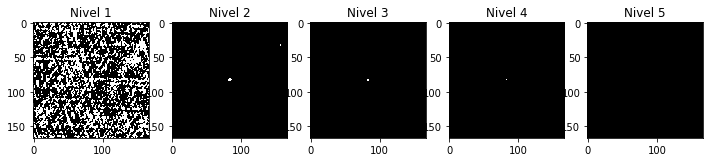

In [13]:
n_plots = n_discrete
f, ax = plt.subplots(1, n_plots, figsize=(12,15))
for i in range(0, n_discrete):
    ax[i].imshow(imgd[:,:,i], cmap='gray')
    st = 'Nivel ' + str(i + 1)
    ax[i].set_title(st)
plt.show()

In [14]:
bl = morpho.ball(1)
imgdo = morpho.opening(imgd, bl)

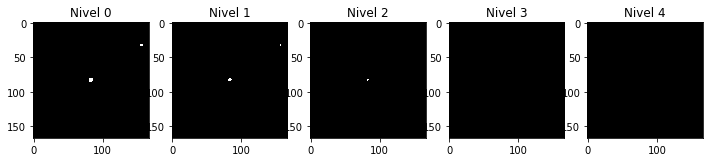

In [15]:
f, ax = plt.subplots(1, n_plots, figsize=(12,15))
for i in range(0, n_plots):
    ax[i].imshow(imgdo[:,:,i], cmap='gray')
    st = 'Nivel ' + str(i)
    ax[i].set_title(st)
plt.show()

In [16]:
@jit(nopython=True)
def white_area(img):
    area = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            area += img[i, j]
    return area
@jit(nopython=True)
def white_area3d(img):
    area = 0
    for x in range(img.shape[2]):
        area += white_area(img[:,:,x])
    return area

In [17]:
%%time
dif = white_area3d(imgd) - white_area3d(imgdo)
print (dif)

10118.0
CPU times: user 133 ms, sys: 1.76 ms, total: 135 ms
Wall time: 134 ms


In [24]:
def get_morphology_info(img, n_discrete):
    imgd, min_d, max_d = discretize_img(img, n_discrete)
    n_vals = int(n_discrete / 2)
    difs = np.zeros(n_vals * 2)
    o_area = white_area3d(imgd)
    for sz in range(n_vals):
        bl = morpho.ball(sz)
        imgdo = morpho.opening(imgd, bl)
        n_area = white_area3d(imgdo)
        dif = o_area - white_area3d(imgdo)
        difs[sz] = dif
        imgdo = morpho.closing(imgd, bl)
        n_area = white_area3d(imgdo)
        dif = white_area3d(imgdo) - o_area
        difs[sz + n_vals] = dif
    return difs

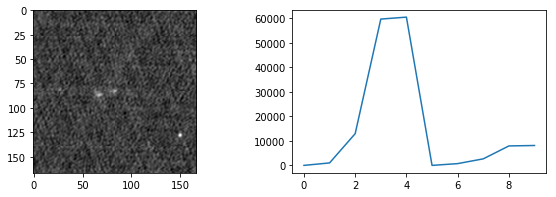

(10,)
CPU times: user 800 ms, sys: 1.98 ms, total: 802 ms
Wall time: 803 ms


In [25]:
%%time
n_div = 10
f, ax = plt.subplots(1, 2, figsize=(10,3))
im = fits.open('{0}/J145627+605750.fits'.format(fits_dir))
img = sk.img_as_float(im[0].data)
ax[0].imshow(img, cmap='gray')
dat = get_morphology_info(img, n_div)
ax[1].plot(dat)
plt.show()
print(dat.shape)

In [26]:
def min_max_img(img):
    min_b, max_b = 10, -100
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i,j] < min_b): min_b = img[i,j]
            if(img[i,j] > max_b): max_b = img[i,j]
    return (min_b, max_b)
def avg_img(img):
    sm = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            sm += img[i,j]
    return sm / ( img.shape[0] * img.shape[1] )

def normalize_img(img):
    min_b, max_b = min_max_img(img)
    range_b = max_b - min_b
    n_img = np.zeros_like(img, dtype=float)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            n_img[i, j] = (img[i, j] - min_b)/ range_b
    return n_img

In [39]:
%%time
import os
directory = os.fsencode(fits_dir)
os.listdir(directory)
n_imgs = 100
i = 0
n_div = 20
info = np.zeros((n_imgs, n_div))
names = [''] * n_imgs
for f in os.listdir(directory):
    filename = os.fsdecode(f)
    im = fits.open('{0}/{1}'.format(fits_dir, filename))
    img = normalize_img(im[0].data)
    dat = get_morphology_info(img, n_div)
    info[i] = dat
    i+= 1
    if(i >= n_imgs) : break
    im.close()

CPU times: user 47min 19s, sys: 39 s, total: 47min 58s
Wall time: 48min 12s


In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
inf_r = pca.fit(info).transform(info)
inf_r.shape

(100, 2)

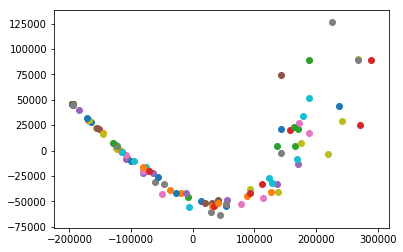

In [41]:
for i in range(inf_r.shape[0]):
    plt.scatter(inf_r[i, 0], inf_r[i, 1])
plt.show()